# OpenJijを使ったイジング最適化

## イジング最適化を使うまでの開発フロー

![](./images/ising_layer.png)

## OpenJijを使ったイジング最適化計算

![](./images/openjij_layer.png)

### イジングモデル

$$E = \sum_{i}\sum_{j \neq i}J_{i,j} \sigma_i \sigma_j + \sum_i h_i \sigma_i,~\sigma_i \in \{-1, 1\}$$

### QUBO (Quadratic unconstrained binary optimization)

$$\min_q \sum_{i, j}Q_{i,j} q_i q_j,~q_i \in \{0, 1\}$$


### イジング <-> QUBO 変換

$$\sigma_i = 2q_i-1$$


### QUBOの式とグラフの対応関係

- 各変数 $q_i$ $~\Longleftrightarrow$　グラフのノード(頂点) $i$
- 変数間の積 $Q_{i,j} q_i q_j~\Longleftrightarrow$ 重み$Q_{i,j}$がついた$i,j$間のエッジ(辺) 


![](./images/4bitQUBO.png)

In [1]:
import openjij as oj

# SA : Simulated Annealing
sampler = oj.SASampler()

# SQA : Simulated Quantum annelling
# sampler = oj.SQASampler()

In [2]:
# QUBOの生成

qubo = {("q0", "q1"): -2, ("q1", "q2"): 1, ("q2", "q3"): 3, ("q3", "q0"): -1, ("q2", "q2"): 2}  # Note: q2 * q2 = q2 (q2 in {0, 1})

In [3]:
# samplerを使って解く

response = sampler.sample_qubo(qubo)

In [4]:
response.samples()[0]

{'q0': 1, 'q1': 1, 'q2': 0, 'q3': 1}

![](./images/4bitQUBOAnswer.png)

## 会議室割り当て問題 (グラフ彩色問題)

![](./images/part1_jijmodeling_layer.png)

$N$個の会議が予定されていますが、会議室は$K (K < N)$個しかない場合、各会議を被らないようにうまく会議室に割り当てましょう。例えば以下のような会議スケジュールがあるとします。

|  Meeting ID  |  Start  | End |
| ---- | ---- | --- |
|  0  |  09:00  | 11:00 |
|  1  |  10:00  | 11:30 |
|  2  |  10:30  | 12:00 |
|  3  |  14:00  | 15:00 |
|  4  |  12:00  | 13:00 |
|  5  |  11:00  | 11:45 |
|  6  |  13:00  | 14:00 |
|  7  |  11:45  | 13:00 |
|  8  |  10:45  | 13:00 |
|  9  |  10:00  | 11:00 |
| 10  |  11:30  | 14:00 |
| 11  |  11:30  | 13:00 |
| 12  |  11:30  | 13:00 |
| 13  |  14:00  | 15:00 |
| 14  |  13:30  | 15:00 |
| 15  |  13:00  | 15:00 |


上記のように会議が16個予定されていますが、会議室が4つしかない場合を考えます。

では、さっそく各会議がかぶらないようにするための会議室割り当てを最適化問題として定式化しましょう。

まず、数理最適化を行う場合は出力したい計画（ここでは会議をどの部屋に割り当てるか）を変数として表現します。今回の割り当てを以下の0-1変数で定義します。

$$x_{v, i} \in \{0, 1\}, v: \text{会議}, i: \text{部屋}$$

ここで$x_{v, i}$は会議$v$を部屋$i$に割り当てるとき1そうでないとき0とする変数です。

この定義により今回は$x$の各値を求めればよいことになります。このように計画に対応するこれから決める変数を「決定変数」と呼びます。

次に各会議のスケジュールを反映するデータを用意します。
会議 $v$を会議$w$の時間がかぶっているとき1でそうでないときに0となるデータ $a_{v, w}$を用意します。

この$a$と$x$を用いて今回最小化しなくてはいけない数式（目的関数）は以下となります。

$$\sum_{v} \sum_{w} \sum_{i=1}^{K} a_{v,w} x_{v, i} x_{w, i}$$

ここで$K$は部屋の数です。この数式は例えば
- $a_{v, w} = 1$のとき => 両方1 ($x_{v, i} = 1, x_{w, i} = 1$) だと $a_{v,w} x_{v, i} x_{w, i} = 1$
- $a_{v, w} = 1$のとき => 片方0 ($x_{v, i} = 0, x_{w, i} = 1$) だと $a_{v,w} x_{v, i} x_{w, i} = 0$
- $a_{v, w} = 0$のとき => 両方1でも ($x_{v, i} = 0, x_{w, i} = 1$) だと $a_{v,w} x_{v, i} x_{w, i} = 0$

となります。つまり会議の時間がかぶっている($a_{v,w} = 1$)とき、会議$v$と会議$w$を同じ部屋$i$に割り当ててしまう($x_{v, i} = 1, x_{w, i} = 1$)と先程の数式の値が大きくなってしまいます。目的関数が0であれば会議室にかぶりがなく各会議を割り当てることができます。

しかし、これだけではどの部屋にも会議を割り当てないというのが答えとして出てくる可能性があるのでそれを防ぐ制約条件を設定します。

それが

$$\sum_{i=1}^{K}x_{v, i} = 1, ~\forall v$$

という制約条件です。各会議に対して部屋の割り当ては一つのみということを意味します。

まとめると解くべき最適化問題は以下です。

$$
\min_x \sum_{v} \sum_{w} \sum_{i=1}^{K} a_{v,w} x_{v, i} x_{w, i}
$$

$$\sum_{i=1}^K x_{v, i} = 1,~\forall v$$
$$x_{v, i} \in \{0, 1\}$$


実はこの会議室割り当て問題は、各会議を頂点として、時間がかぶっている会議同士に線を引くとより最適化問題として見やすくなります。

![](./images/meeting_graph.png)

会議の時間割とグラフは

- 各会議 <-> グラフのノード
- 会議間に時間の被りがある <-> ノード間にエッジが存在

という対応関係を持ちます。

このようにグラフの問題に変換すると、

- 会議を`会議に重複がない`ように`会議室を割り当てる` 問題

という問題を

- `繋がっているノードは別の色`になるように`ノードに色を塗る`問題 (グラフ彩色問題)

に変換することができます。

### QUBOへの変換

制約条件を罰金項へ変換

$$
\min_x \sum_{v} \sum_{w} \sum_{i=1}^{K} a_{v,w} x_{v, i} x_{w, i}
+A\sum_v \left(\sum_{i=1}^K x_{v, i} -1\right)^2\\
x_{v, i} \in \{0, 1\}
$$

![](./images/graph_coloring_qubo.png)


## OpenJijで解いてみよう

先程の会議スケジュールを頂点と線で書いたグラフで表示してみましょう。以下のセルを Shift + Enter で実行してみてください。

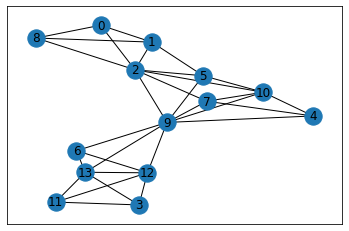

In [5]:
from typing import Tuple
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

timetable = [
    (9, 11),    (10, 11.5),
    (10.5, 12), (14, 15),
    (12, 13), (11, 11.7),
    (13, 14),
    (11.7, 13), (10, 11),
    (11.5, 14), (11.5, 13),
    (14, 15),
    (13.5, 15), (13, 15),
]

edge_list = []
adjacency_matrix = np.zeros((len(timetable), len(timetable)))

def has_edge(meeting1: Tuple[float, float], meeting2: Tuple[float, float]):
    if not meeting1[1] <= meeting2[0]:
        if not meeting2[1] <= meeting1[0]:
            return True
    return False

for u, meeting_u in enumerate(timetable[:-1]):
    for _v, meeting_v in enumerate(timetable[u+1:]):
        v = u + _v + 1
        if has_edge(meeting_u, meeting_v):
            edge_list.append((u, v))
            adjacency_matrix[u, v] = 1
            adjacency_matrix[v, u] = 1

graph = nx.Graph()
graph.add_edges_from(edge_list)
nx.draw_networkx(graph)
plt.show()

### JijModelingを使ったQUBOモデリング

In [6]:
import jijmodeling as jm

In [7]:
a = jm.Placeholder("a", dim=2)
N = a.shape[0].set_latex("N")
C = jm.Placeholder("C")

x = jm.Binary("x", shape=(N, C))

v, w = jm.Element("v", (0, N)), jm.Element("w", (0, N))
i = jm.Element("i", (0, C))

problem = jm.Problem("graph coloring")

# Cost term
problem += jm.Sum([v, w, i], a[v, w]*x[v, i] * x[w, i])

# Penalty term
problem += jm.Penalty("one-color",(jm.Sum(i, x[v, i]) - 1)**2, forall=v)

In [9]:
# PyQUBOへの変換
ph_value = {
    "n": len(timetable),
    "a": adjacency_matrix,
    "C": 4
}
pyq_obj = problem.to_pyqubo(ph_value=ph_value)

In [10]:
qubo, const = pyq_obj.compile().to_qubo(feed_dict={"one-color": 1})

In [11]:
response = sampler.sample_qubo(qubo)

In [12]:
decoded = problem.decode(response, ph_value=ph_value)

In [13]:
decoded.solutions[0]

{'x': array([[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])}

## JijModelingを使った数理モデリング

In [14]:
a = jm.Placeholder("a", dim=2)
N = a.shape[0].set_latex("N")
C = jm.Placeholder("C")

x = jm.Binary("x", shape=(N, C))

v, w = jm.Element("v", (0, N)), jm.Element("w", (0, N))
i = jm.Element("i", (0, C))

problem = jm.Problem("graph coloring")

# Cost term
problem += jm.Sum([v, w, i], a[v, w]*x[v, i] * x[w, i])

# Penalty term
problem += jm.Constraint("one-color", jm.Sum(i, x[v, i]) == 1, forall=v)
problem

In [15]:
pyq_obj = problem.to_pyqubo(ph_value=ph_value)
pyq_compiled = pyq_obj.compile()

In [16]:
qubo, const = pyq_compiled.to_qubo(feed_dict={"one-color": 3})

In [17]:
response = sampler.sample_qubo(qubo)
decoded = problem.decode(response, ph_value=ph_value)

In [18]:
decoded

DecodedSamples(feasibles = 1[/1], objective = 0.0, energy = -42.0)

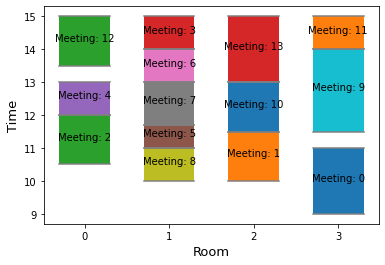

In [19]:
def plot_timetable(timetable, solution):
    rooms = solution
    assignment = {i: r for i, r in enumerate(rooms)}
    for meeting, room in assignment.items():
        plt.plot([room - 0.3, room + 0.3], [timetable[meeting][0]]*2, color='gray')
        plt.plot([room - 0.3, room + 0.3], [timetable[meeting][1]]*2, color='gray')
        plt.fill_between([room - 0.3, room + 0.3], [timetable[meeting][0]]*2, [timetable[meeting][1]]*2)
        plt.text(room, np.mean(timetable[meeting]), 'Meeting: '+ str(meeting), ha='center', fontsize=10)
    plt.xticks(list(range(min(rooms), max(rooms)+1)))
    plt.xlabel('Room', fontsize=13)
    plt.ylabel('Time', fontsize=13)

x_value = decoded.solutions[0]['x']
solution = np.where(x_value == 1)[1]
plot_timetable(timetable, solution)
plt.show()

## パラメータ調整

In [21]:
degree = np.sum(adjacency_matrix, axis=0)
qubo, const = pyq_compiled.to_qubo(feed_dict={"one-color": 1})

response = sampler.sample_qubo(qubo, num_reads=30)
decoded = problem.decode(response, ph_value=ph_value)
decoded

DecodedSamples(feasibles = 21[/30], objective = 0.0, energy = -14.0)

In [22]:
decoded.objectives

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [24]:
param_strangth = np.linspace(0.5, 5, 20)
num_reads = 30
objective = []
const_violation = []
num_feasible = []
for p in param_strangth:
    qubo, const = pyq_compiled.to_qubo(feed_dict={"one-color": p})
    response = sampler.sample_qubo(qubo, num_reads=num_reads)
    decoded = problem.decode(response, ph_value=ph_value)
    objective.append(np.mean(decoded.objectives))
    const_violation.append(np.mean([violation['one-color'] for violation in decoded.constraint_violations]))
    num_feasible.append(len(decoded.feasibles()))

Text(0, 0.5, 'number of feasible')

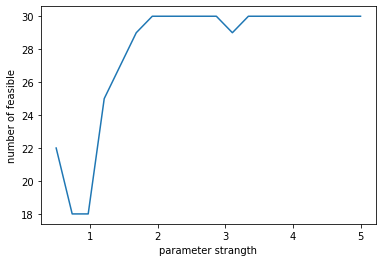

In [25]:
plt.plot(param_strangth, num_feasible)
plt.xlabel("parameter strangth")
plt.ylabel("number of feasible")

[]

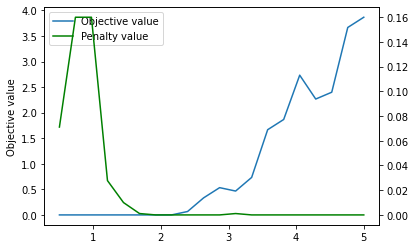

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(param_strangth, objective, label="Objective value")
ax1.set_ylabel("Objective value")
ax2.plot(param_strangth, np.array(const_violation)**2, c="g", label="Penalty value")

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2)
plt.plot()